# Markov Chains and Hidden Markov Models  

### George Tzanetakis, University of Victoria 

Trong sổ tay này, chúng ta sẽ khám phá các mô hình markov ẩn. Chúng tôi bắt đầu với các biến ngẫu nhiên và một mô hình phân bố giống hệt, độc lập đơn giản về thời tiết. Sau đó, chúng tôi xem xét cách hình thành Chuỗi Markov để chuyển đổi giữa các trạng thái và cuối cùng chúng tôi lấy mẫu Mô hình Markov ẩn để hiển thị cách tạo mẫu dựa trên Chuỗi Markov của các trạng thái ẩn. Các kết quả được hiển thị dưới dạng dải hình chữ nhật màu. Thử nghiệm xác suất chuyển tiếp và xác suất phát xạ để hiểu rõ hơn về cách Mô hình Markov ẩn hoạt động trong việc tạo dữ liệu. 


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import warnings
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler
import plotly as py
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm
import warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

import matplotlib.font_manager
import matplotlib.pyplot as plt

# Đặt lại kiểu font mặc định
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'DejaVu Sans'})

Trước tiên chúng ta hãy tạo một số mẫu ngẫu nhiên của biến ngẫu nhiên tượng trưng tương ứng với thời tiết với hai giá trị Nắng (S) và mây (C) và tạo thời tiết ngẫu nhiên trong 365 ngày. Giả định trong mô hình này là thời tiết mỗi ngày không phụ thuộc vào những ngày trước đó và được rút ra từ cùng một phân bố xác suất.

In [6]:
class Random_Variable: 
    
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution 
        if all(type(item) is np.int64 for item in values): 
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self,size): 
        if (self.type =='numeric'): 
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'): 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples 
        
    def probs(self): 
        return self.probability_distribution
    
    def vals(self): 
        print(self.type)
        return self.values 

In [24]:
values = ['S', 'C']
probabilities = [0.5, 0.5]
weather = Random_Variable('weather', values, probabilities)
samples = weather.sample(365)

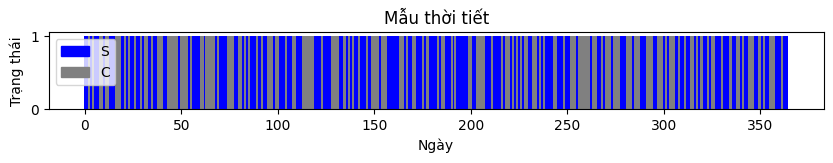

In [29]:
state2color = {} 
state2color['S'] = 'blue'
state2color['C'] = 'grey'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10, 1))
    plt.bar(x, y, color=colors, width=1)
    plt.title('Mẫu thời tiết')
    plt.xlabel('Ngày')
    plt.ylabel('Trạng thái')
    
    # Thêm chú thích
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=color, label=state) for state, color in state2color.items()]
    plt.legend(handles=patches, loc='upper left')
    plt.show()
    
plot_weather_samples(samples, state2color)

In [30]:
def markov_chain(transmat, state, state_names, samples): 
    (rows, cols) = transmat.shape 
    rvs = [] 
    values = list(np.arange(0,rows))
    
    # create random variables for each row of transition matrix 
    for r in range(rows): 
        rv = Random_Variable("row" + str(r), values, transmat[r])
        rvs.append(rv)
    
    states = [] 
    for n in range(samples): 
        state = rvs[state].sample(1)[0]    
        states.append(state_names[state])
    return states

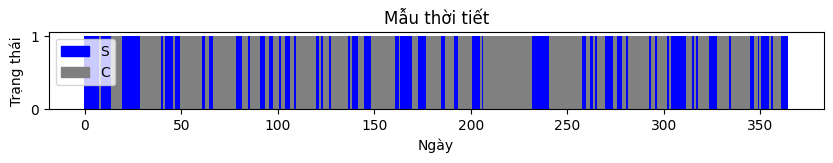

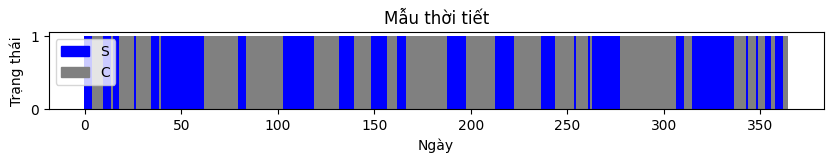

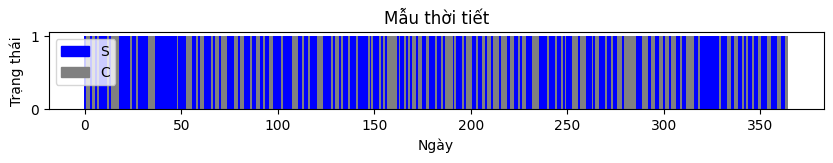

In [31]:
# Ma trận chuyển đổi cho chuỗi Markov
transmat1 = np.array([[0.7, 0.3], 
                      [0.2, 0.8]])

transmat2 = np.array([[0.9, 0.1], 
                      [0.1, 0.9]])

transmat3 = np.array([[0.5, 0.5], 
                      [0.5, 0.5]])

# Đặt tên cho các trạng thái
state_names = ['S', 'C']

# Tạo chuỗi Markov từ ma trận chuyển đổi đầu tiên
samples1 = markov_chain(transmat1, 0, state_names, 365)
plot_weather_samples(samples1, state2color)

# Tạo chuỗi Markov từ ma trận chuyển đổi thứ hai
samples2 = markov_chain(transmat2, 0, state_names, 365)
plot_weather_samples(samples2, state2color)

# Tạo chuỗi Markov từ ma trận chuyển đổi thứ ba
samples3 = markov_chain(transmat3, 0, state_names, 365)
plot_weather_samples(samples3, state2color)

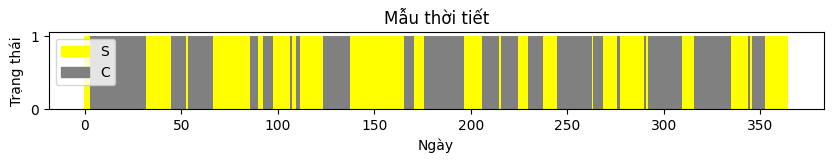

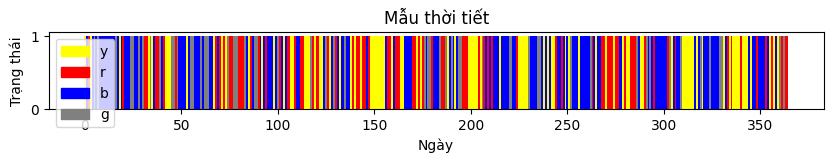

In [32]:
state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

samples = weather.sample(365)
states = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(states, state2color)

sunny_colors = Random_Variable('sunny_colors', ['y', 'r', 'b', 'g'], 
                              [0.4, 0.4, 0.1, 0.1])
cloudy_colors = Random_Variable('cloudy_colors', ['y', 'r', 'b', 'g'], 
                               [0.1, 0.1, 0.6, 0.2])

def emit_sample(state, sunny_colors, cloudy_colors): 
    if (state == 'S'): 
        sample = sunny_colors.sample(1)[0]
    else: 
        sample = cloudy_colors.sample(1)[0]
    return sample 

samples = [emit_sample(s, sunny_colors, cloudy_colors) for s in states]
state2color = {} 
state2color['y'] = 'yellow'
state2color['r'] = 'red'
state2color['b'] = 'blue'
state2color['g'] = 'grey'
plot_weather_samples(samples, state2color)

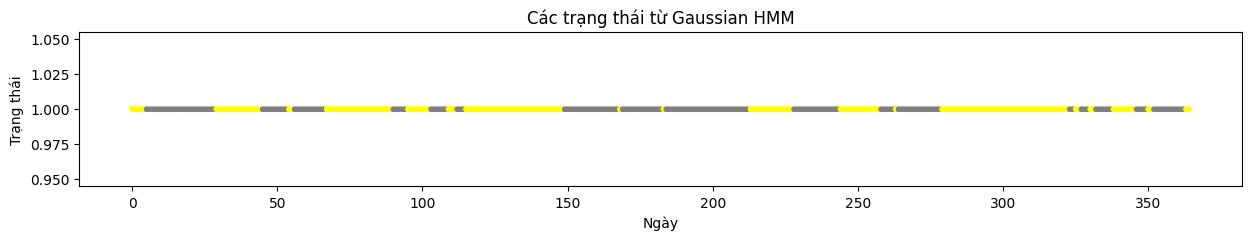

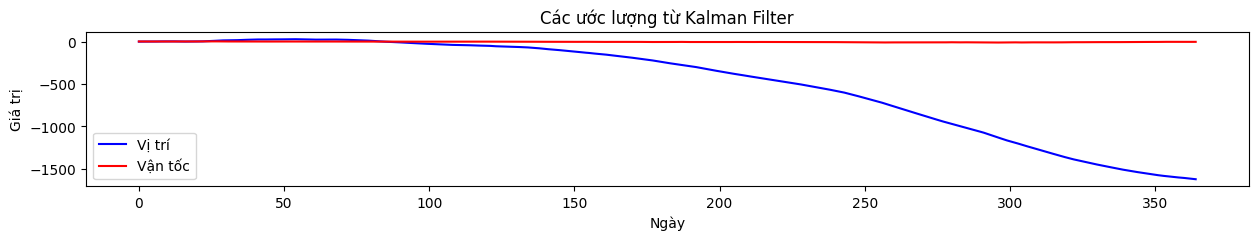

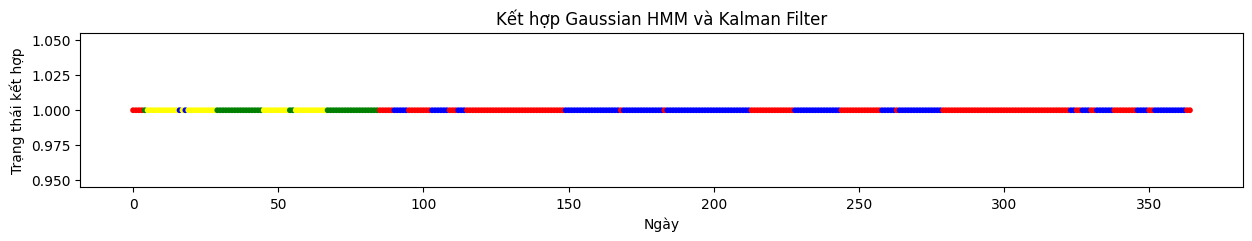

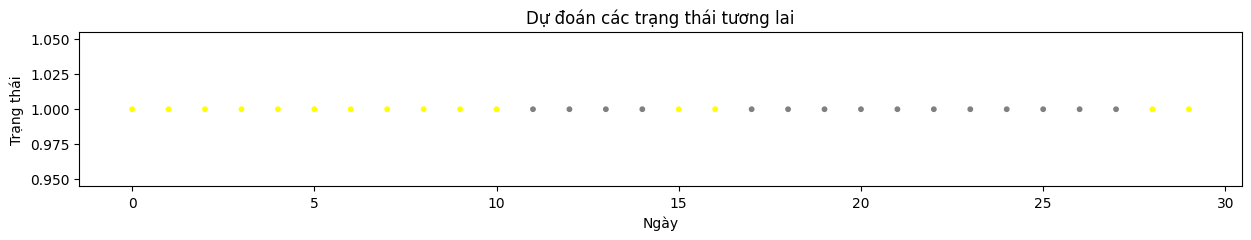

In [35]:
transmat = np.array([[0.9, 0.1], 
                     [0.1, 0.9]])

start_prob = np.array([1.0, 0.0])

means = np.array([[0.0], [3.0]])
covars = np.array([[[1.0]], [[0.5]]])

model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
model.startprob_ = start_prob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

# Tạo dữ liệu
X, Z = model.sample(365)
hmm_states = model.predict(X)

state2color = {0: 'yellow', 1: 'grey'}

# Hàm để vẽ các mẫu thời tiết
def plot_weather_samples(states, state2color, title):
    colors = [state2color[state] for state in states]
    plt.figure(figsize=(15, 2))
    plt.scatter(range(len(states)), [1] * len(states), c=colors, s=10)
    plt.title(title)
    plt.xlabel('Ngày')
    plt.ylabel('Trạng thái')
    plt.show()

# Vẽ các trạng thái từ HMM
plot_weather_samples(hmm_states, state2color, 'Các trạng thái từ Gaussian HMM')

# Thiết lập Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.array([[1, 1], [0, 1]]),
    observation_matrices=np.array([[1, 0]]),
    initial_state_mean=np.array([0, 1]),
    initial_state_covariance=np.array([[1, 0.1], [0.1, 1]]),
    observation_covariance=1,
    transition_covariance=np.array([[0.1, 0], [0, 0.1]])
)

kalman_states, _ = kf.sample(365)

# Vẽ các ước lượng từ Kalman Filter
plt.figure(figsize=(15, 2))
plt.plot(kalman_states[:, 0], 'b-', label='Vị trí')
plt.plot(kalman_states[:, 1], 'r-', label='Vận tốc')
plt.title('Các ước lượng từ Kalman Filter')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.legend()
plt.show()

# Kết hợp các kết quả
combined_states = np.hstack((hmm_states.reshape(-1, 1), kalman_states[:, 0:1]))

# Định nghĩa bản đồ màu mới cho các trạng thái kết hợp
combined_state2color = {(0, 0): 'red', (0, 1): 'green', (1, 0): 'blue', (1, 1): 'yellow'}
combined_colors = [combined_state2color[(hmm_state, int(kalman_state > 0))] for hmm_state, kalman_state in zip(hmm_states, kalman_states[:, 0])]

# Vẽ kết quả kết hợp
plt.figure(figsize=(15, 2))
plt.scatter(range(len(combined_colors)), [1] * len(combined_colors), c=combined_colors, s=10)
plt.title('Kết hợp Gaussian HMM và Kalman Filter')
plt.xlabel('Ngày')
plt.ylabel('Trạng thái kết hợp')
plt.show()

# Dự đoán các trạng thái tương lai
future_steps = 30
future_states = model.predict(X[-future_steps:])

# Hiển thị các trạng thái tương lai dự đoán
plot_weather_samples(future_states, state2color, 'Dự đoán các trạng thái tương lai')

In [ ]:
model = hmm.MultinomialHMM(n_components=2, n_iter=100, random_state=42)
model.fit(observations)

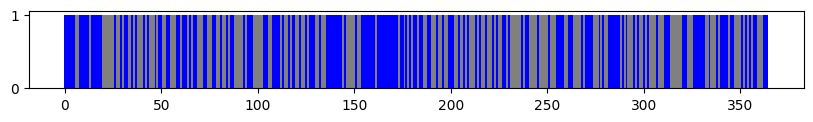

In [11]:
state2color = {} 
state2color['S'] = 'blue'
state2color['C'] = 'grey'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    
plot_weather_samples(samples, state2color)

Now instead of independently sampling the weather random variable lets form a markov chain. 

AttributeError: 'list' object has no attribute 'head'

In [ ]:
def markov_chain(transmat, state, state_names, samples): 
    (rows, cols) = transmat.shape 
    rvs = [] 
    values = list(np.arange(0,rows))
    
    # create random variables for each row of transition matrix 
    for r in range(rows): 
        rv = Random_Variable("row" + str(r), values, transmat[r])
        rvs.append(rv)
    
    # start from initial state and then sample the appropriate 
    # random variable based on the state following the transitions 
    states = [] 
    for n in range(samples): 
        state = rvs[state].sample(1)[0]    
        states.append(state_names[state])
    return states


# transition matrices for the Markov Chain 
transmat1 = np.array([[0.7, 0.3], 
                    [0.2, 0.8]])

transmat2 = np.array([[0.9, 0.1], 
                    [0.1, 0.9]])

transmat3 = np.array([[0.5, 0.5], 
                     [0.5, 0.5]])



# plot the iid model too

state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'
samples = weather.sample(365)

plot_weather_samples(samples, state2color)

samples1 = markov_chain(transmat1,0,['S','C'], 365)
plot_weather_samples(samples1, state2color)

samples2 = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(samples2, state2color)

samples3 = markov_chain(transmat3,0,['S','C'], 365)
plot_weather_samples(samples3, state2color)


Lets now look at how a Hidden Markov Model would work by having a Markov Chain to generate 
a sequence of states and for each state having a different emission probability. When sunny we will output red or yellow with higher probabilities and when cloudy black or blue. First we will write the code directly and then we will use the hmmlearn package. 

In [ ]:
state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

samples = weather.sample(365)
states = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(states, state2color)

sunny_colors = Random_Variable('sunny_colors', ['y', 'r', 'b', 'g'], 
                              [0.4, 0.4, 0.1, 0.1])
cloudy_colors = Random_Variable('cloudy_colors', ['y', 'r', 'b', 'g'], 
                               [0.1, 0.1, 0.6, 0.2])

def emit_sample(state, sunny_colors, cloudy_colors): 
    if (state == 'S'): 
        sample = sunny_colors.sample(1)[0]
    else: 
        sample = cloudy_colors.sample(1)[0]
    return sample 

samples = [emit_sample(s, sunny_colors, cloudy_colors) for s in states]
state2color = {} 
state2color['y'] = 'yellow'
state2color['r'] = 'red'
state2color['b'] = 'blue'
state2color['g'] = 'grey'
plot_weather_samples(samples, state2color)





In [ ]:
# transmat = np.array([[0.9, 0.1], 
#                     [0.1, 0.9]])

# start_prob = np.array([1.0, 0.0, 0.0])

# # yellow and red have high probs for sunny 
# # blue and grey have high probs for cloudy 
# emission_probs = np.array([[0.4, 0.4, 0.1, 0.1], 
#                            [0.1, 0.1, 0.6, 0.2]])

# model = hmm.MultinomialHMM(n_components=2)
# model.startprob_ = start_prob 
# model.transmat_ = transmat 
# model.emissionprob_ = emission_probs

# # sample the model - X is the observed values 
# # and Z is the "hidden" states 
# X, Z = model.sample(365)

# state2color = {} 
# state2color[0] = 'yellow'
# state2color[1] = 'grey'
# plot_weather_samples(Z, state2color)

# samples = [item for sublist in X for item in sublist]

# state2color = {} 
# state2color[0] = 'yellow'
# state2color[1] = 'red'
# state2color[2] = 'blue'
# state2color[3] = 'grey'
# plot_weather_samples(samples, state2color)



In [ ]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Transition matrix for 2 states
transmat = np.array([[0.9, 0.1], 
                     [0.1, 0.9]])

# Start probabilities for 2 states
start_prob = np.array([1.0, 0.0])

# Emission probabilities
# Yellow and red have high probs for sunny 
# Blue and grey have high probs for cloudy 
emission_probs = np.array([[0.4, 0.4, 0.1, 0.1], 
                           [0.1, 0.1, 0.6, 0.2]])

# Create the HMM model with 2 states
model = hmm.MultinomialHMM(n_components=2, n_trials=1)  # Set n_trials here
model.startprob_ = start_prob 
model.transmat_ = transmat 
model.emissionprob_ = emission_probs

# Sample the model - X is the observed values and Z is the "hidden" states 
X, Z = model.sample(365)

# Define state to color mapping for plotting
state2color = {0: 'yellow', 1: 'grey'}

# Function to plot weather samples
def plot_weather_samples(states, state2color):
    colors = [state2color[state] for state in states]
    plt.figure(figsize=(15, 2))
    plt.scatter(range(len(states)), [1] * len(states), c=colors, s=10)
    plt.show()

plot_weather_samples(Z, state2color)

# Flatten the samples
samples = [item for sublist in X for item in sublist]

# Update the state2color mapping for the observed values
state2color = {0: 'yellow', 1: 'red', 2: 'blue', 3: 'grey'}

plot_weather_samples(samples, state2color)
